In [1]:
import torch
from model import Model
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)

device = torch.device("cpu")

model_name_or_path = "microsoft/codebert-base"

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    'openai-gpt': (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    'bert': (BertConfig, BertForMaskedLM, BertTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES['roberta'] 

config = RobertaConfig.from_pretrained(model_name_or_path, cache_dir=None, output_attentions=True)

config.num_labels=1
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path,
                                            do_lower_case=False,
                                            cache_dir=None)
block_size = 20

In [2]:
model = RobertaForSequenceClassification(config)
model=Model(model, config, tokenizer, None)
# load checkpoints 
checkpoint_prefix = "./saved_models/checkpoint-best-acc/model.bin"
model.load_state_dict(torch.load(checkpoint_prefix)) 
model = model.to(device)

In [3]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 idx,
                 label):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.idx=str(idx)
        self.label=label
        
def convert_examples_to_features(js, tokenizer, block_size=512):
    #source
    code=' '.join(js['func'].split())
    code_tokens=tokenizer.tokenize(code)[:block_size-2]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids+=[tokenizer.pad_token_id]*padding_length
    
    return InputFeatures(source_tokens,source_ids,js['idx'],js['target'])

In [4]:
js = {'func': 'def max(a,b): if a>b: return a else: return b', 'idx': 0, 'target': 0}

code_example = convert_examples_to_features(js, tokenizer, block_size=block_size)

input_ids = torch.tensor([code_example.input_ids])
input_labels = torch.tensor([code_example.label])
input_tokens = code_example.input_tokens
attention_mask=input_ids.ne(1)

In [5]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

# generate reference indices for each sample
token_reference = TokenReferenceBase(reference_token_idx=ref_token_id) # use padding_idx for roberta
seq_length = len(code_example.input_ids)
reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

In [7]:
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm
    
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

In [8]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'encoder.roberta.embeddings.word_embeddings')

def construct_whole_bert_embeddings(input_ids, ref_input_ids):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
    
    return input_embeddings, ref_input_embeddings

/home/fjiriges/anaconda3/envs/cuBERT/lib/python3.8/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [9]:
def predict_forward_func(inputs):
    logit, pred = model(inputs_embeds=inputs)
    pred = pred[0]
    
    
    return pred[0]

In [15]:
layer_attrs_start = []
layer_attrs_end = []

layer_attn_mat_start = []
layer_attn_mat_end = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, reference_indices)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(predict_forward_func, 
                          model.encoder.roberta.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, 
                                            baselines=ref_input_embeddings, 
                                            additional_forward_args=())
    layer_attributions_end = lc.attribute(inputs=input_embeddings, 
                                          baselines=ref_input_embeddings, 
                                          additional_forward_args=())
    
    layer_attrs_start.append(summarize_attributions(layer_attributions_start[0]))
    layer_attrs_end.append(summarize_attributions(layer_attributions_end[0]))

    layer_attn_mat_start.append(layer_attributions_start[1])
    layer_attn_mat_end.append(layer_attributions_end[1])

In [16]:
# layer x seq_len
layer_attrs_start = torch.stack(layer_attrs_start)

In [17]:
# layer x batch x head x seq_len x seq_len
layer_attn_mat_start = torch.stack(layer_attn_mat_start)

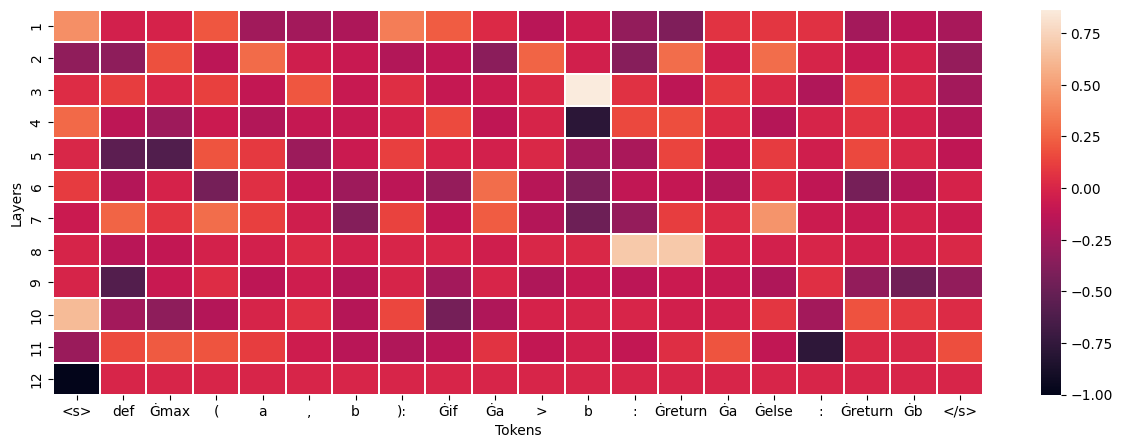

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
xticklabels=input_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(layer_attrs_start.cpu().detach().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

In [19]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(input_tokens)))
        ax.set_yticks(range(len(input_tokens)))

        ax.set_xticklabels(input_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(input_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [20]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(input_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(input_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

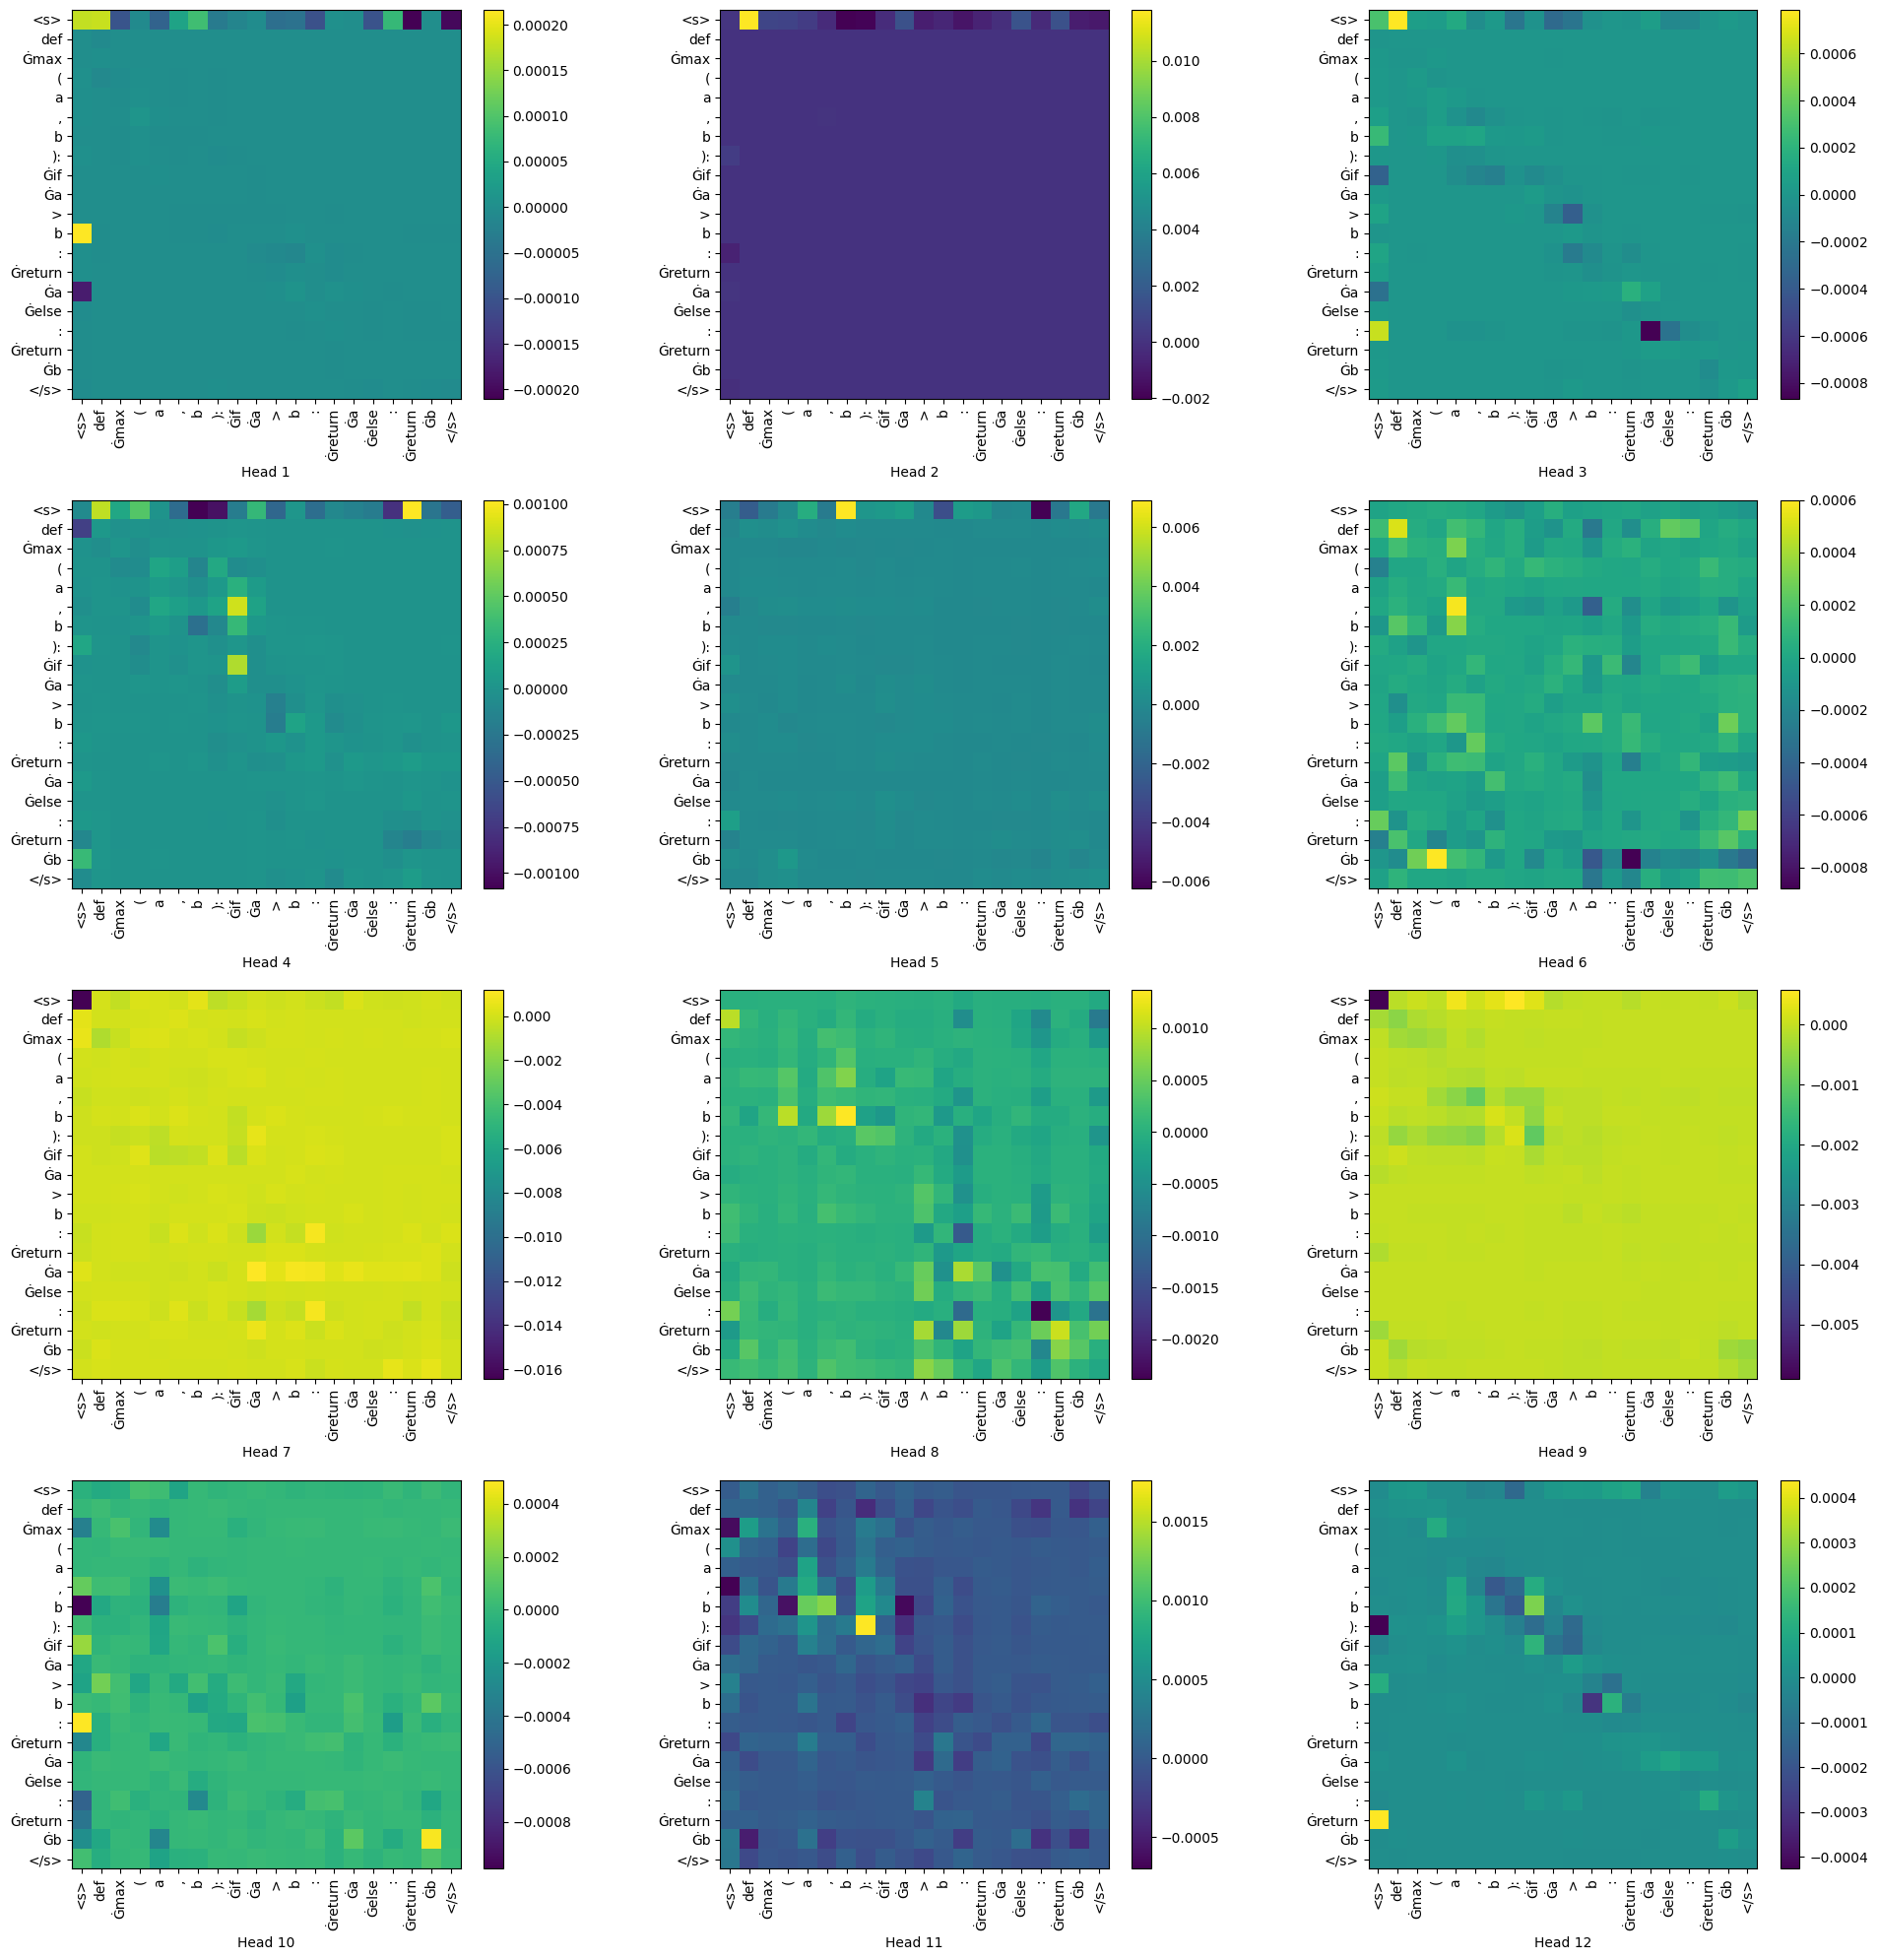

In [22]:
layer = 10
visualize_token2token_scores(layer_attn_mat_start[layer].squeeze().cpu().detach().numpy())

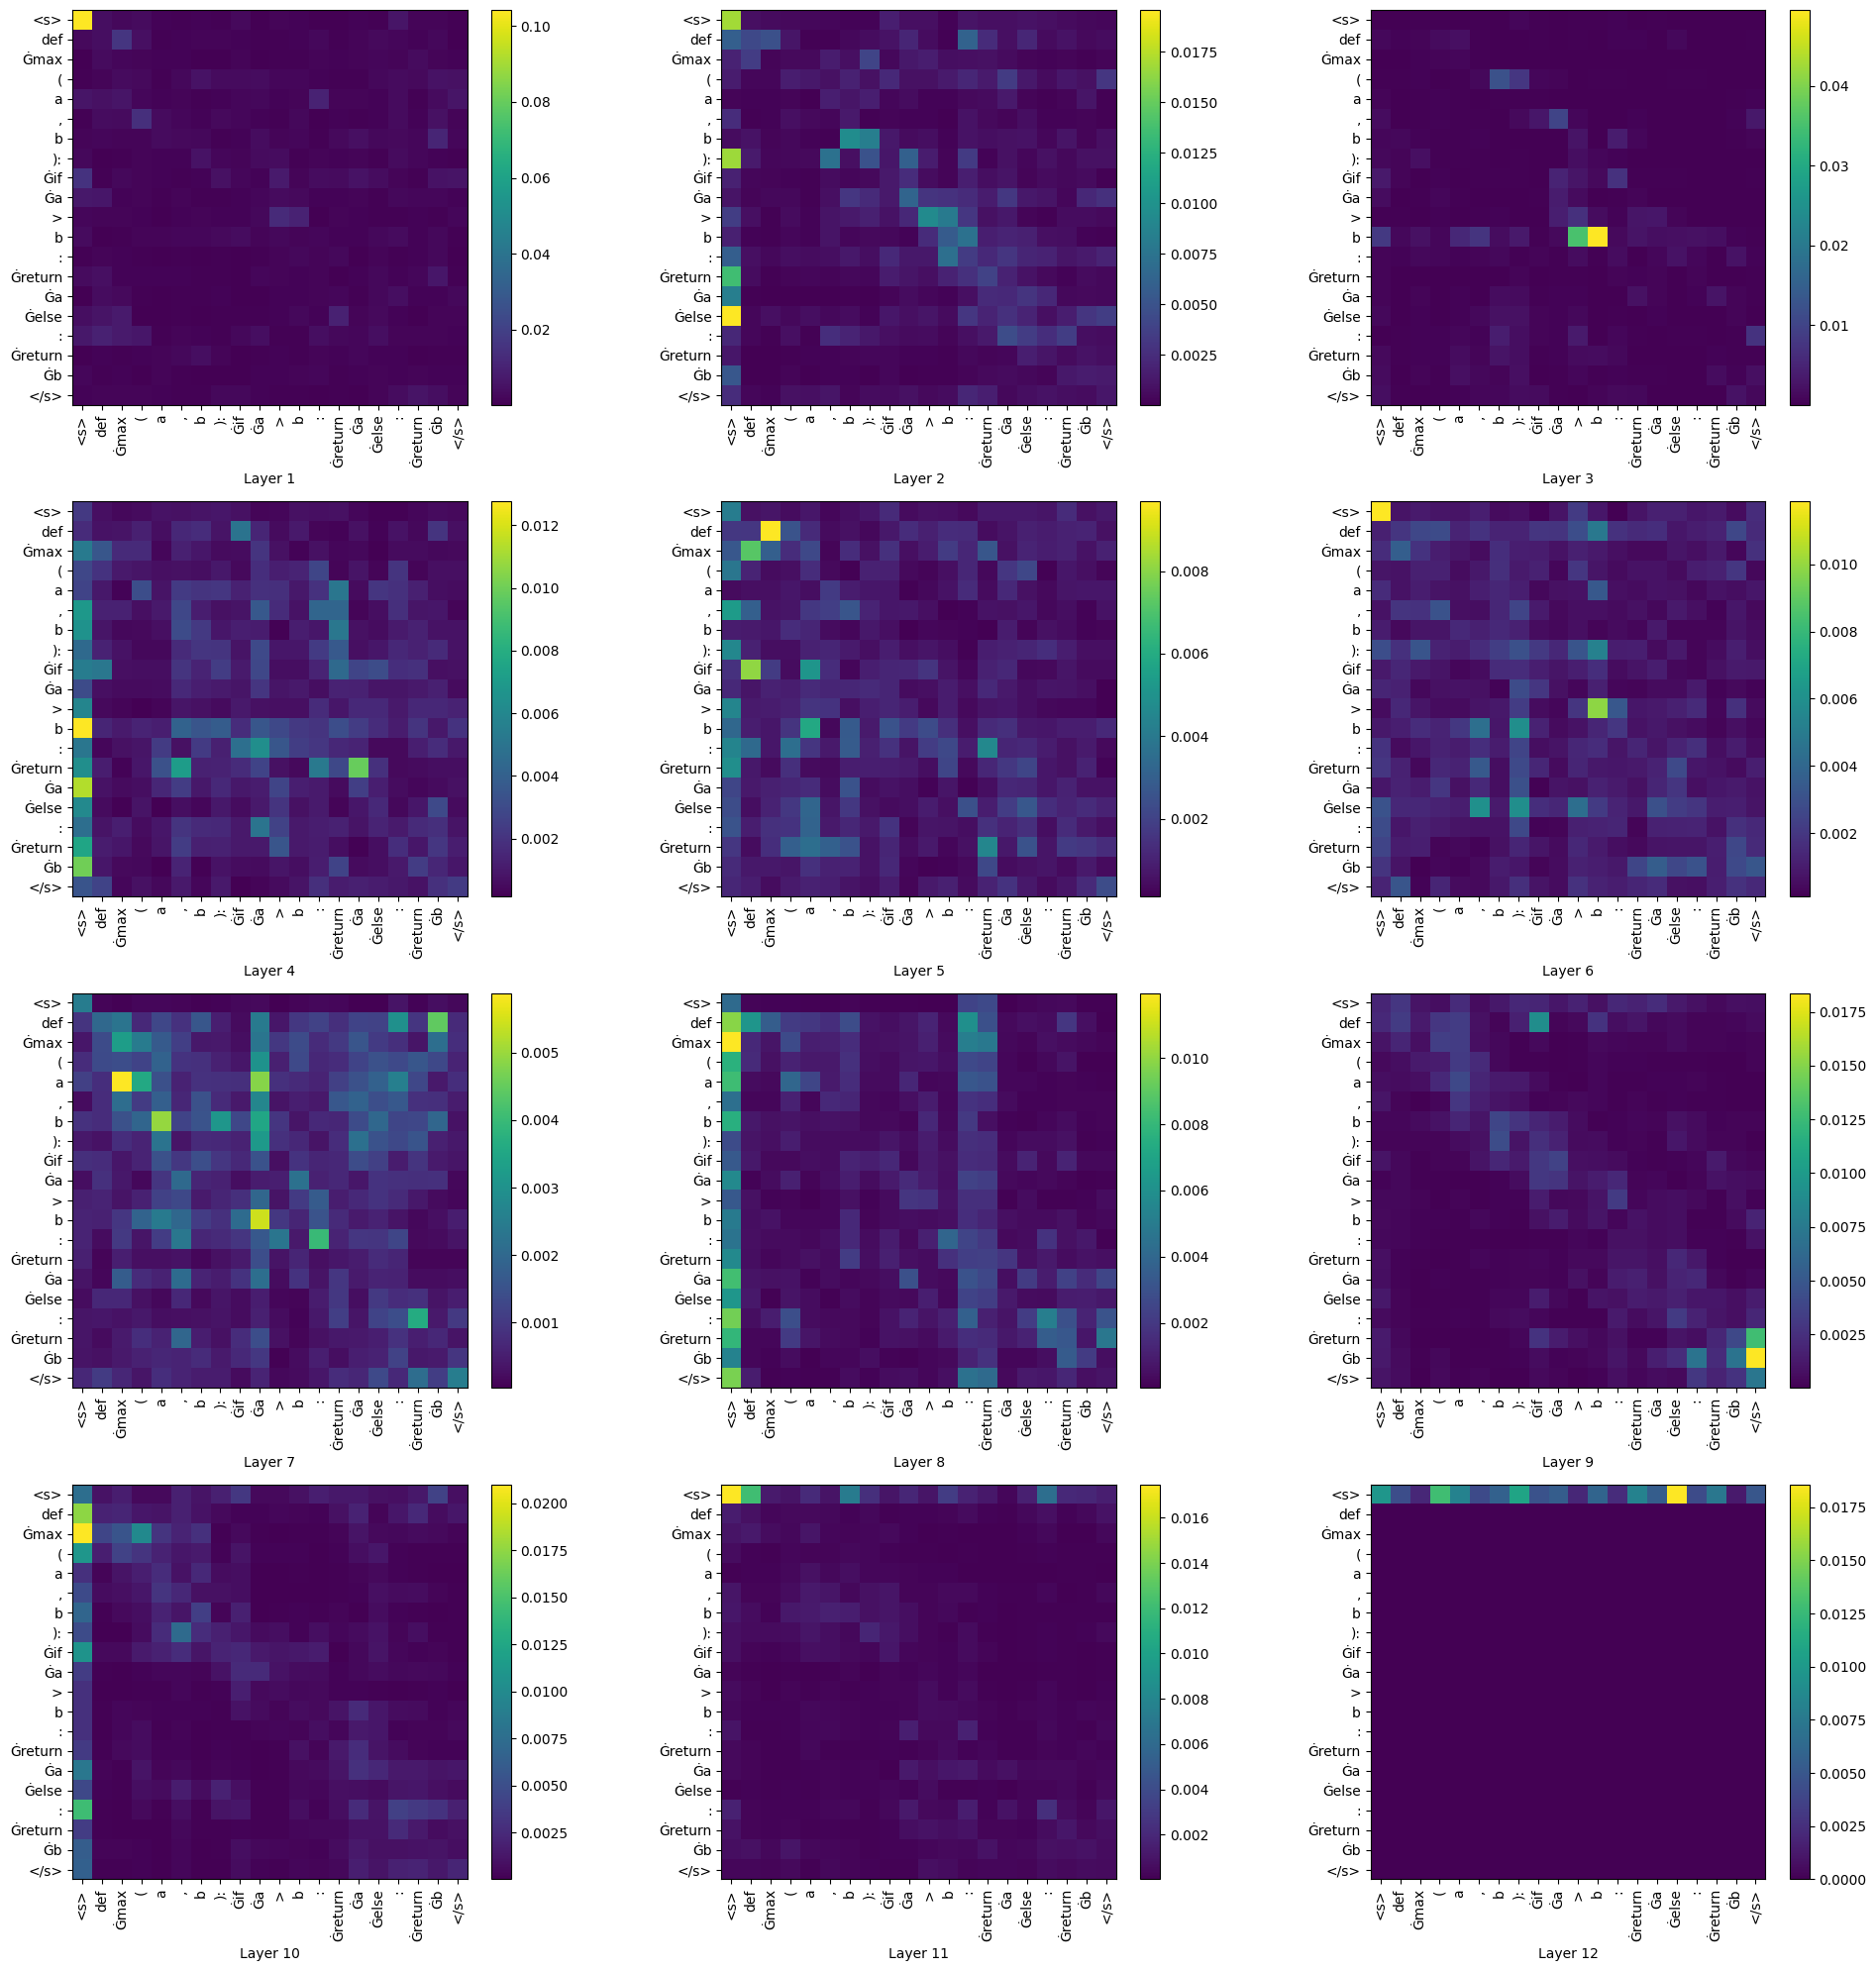

In [23]:
visualize_token2token_scores(norm_fn(layer_attn_mat_start, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')